<center><strong><font size=+4>HERA Memo 68: H1C IDR 2.2</font>
<br><br><em><font size=+1>Calibrated, Flagged, and LST-Binned HERA Internal Data Release</font></strong></em></center>
<br><br>
<center><strong><font size=+2>Josh Dillon</font><br><em>on behalf of the HERA Analysis Team</em></strong></center>
<br><center><strong><font size=+1>May TODO, 2019</font></strong></center>

H1C IDR 2.2 is a re-release of 18 days of calibrated data products from late 2017, part of [HERA](http://reionization.org/)'s first science observing season. It follows up on IDR 2.1, our first internal data release. That release was [described in this memo at reionization.org](http://reionization.org/wp-content/uploads/2018/07/IDR2.1_Memo_v2.html). This memo builds on that memo, and though the overlap is substantial, ID2.2 has a number of improvements:

* **Python 3 support**: All modules (at least for now) support both Python 2 and 3 and the pipeline was run on Python 3.7.
* **File format change**: We've moved form using miriad files to uvh5 files. This enables improved partial I/O.
* **4-pol data files, 2-pol calibration files**: All data files now contain all four instrumental polarizations, all calibration files now contain both antenna polarizations.
* **Bad antennas included in calibration files**: Flagged antennas are now included in calibration files, through their flags are all set to `True`. Previously, they were simply excluded.
* **Fewer visibility files saved**: With the exception of delay-filtered data, we no longer produce any of the day-by-day calibrated/flagged data products that can be trivially reconstructed from calibration files and raw data. This saves considerable disk space. It is not true of LST-binned data.
* **Improved redundant calibration**: Redundant calibration is now performed with an generalized firstcal, a new pure-python `omnical`, and proper normalization of $\chi^2 / DoF$.
* **Improved absolute calibration**: The externally calibrated set of "model" visibilities has been improved by including more sources and ignoring short baselines (under 40 m). Also, abscal calibration files now contain their own $\chi^2$ and $\chi^2$ per antenna, which compare calibrated data to the abscal model.
* **Improved RFI flagging**: RFI flagging has been systematized and rationalized to produce a single flag waterfall (per time and frequency, but not per antenna or baseline) using metrics of "outlierness" from both raw data and calibration data products, combined in quadrature. 
* **Improved calibration smoothing**: Instead of smoothing in time and then in frequency, we now perform a 2D smoothing using an iterative CLEAN-like algorithm.
* **Various new ancillary day-by-data data products**:
    * Multi-frequency synthesis imaging using CASA
    * Fits to cable reflections
    * Estimates of the noise on calibrated data
    * Extracted raw autocorrelations


This `jupyter notebook` memo is designed to be run when logged into NRAO. In addition to the standard python libraries, it requires [pyuvdata](https://github.com/HERA-Team/pyuvdata), [hera_cal](https://github.com/HERA-Team/hera_cal), and [hera_qm](https://github.com/HERA-Team/hera_qm/). For more information on access, see the [HERA wiki](http://hera.pbworks.com/w/page/119477181/NRAO%20Computing). For ongoing discussions, join the [#hera-analysis Slack channel](https://eoranalysis.slack.com/messages/C3ZPGMG3E) or our 
telecons on Wednesdays at 10am Pacific in the HERA Zoom room.

In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np

The day-by-day data, along with the pipeline settings file used (`idr_v1.cfg`), and the LST-binned data can be found in:

In [2]:
!ls /lustre/aoc/projects/hera/H1C_IDR2/IDR2_2/

2458098  2458102  2458105  2458108  2458111  2458114  makeflow
2458099  2458103  2458106  2458109  2458112  2458115  setup_folders.sh
2458101  2458104  2458107  2458110  2458113  2458116


In [83]:
analysis_folder = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_2'
analysis_folder = '/lustre/aoc/projects/hera/jsdillon/idr2_2_testing'
analysis_folder = '/lustre/aoc/projects/hera/plaplant/H1C_IDR2/v2'

## Finding and Loading Data
H1C IDR 2.2 includes 18 nearly-consecutive nights of data. All data products are sorted by JD into the following folders on the NRAO servers, which also contain softlinks to raw H1C IDR 2 data in the `.uvh5` format and antenna metrics released by the commissioning team. Each night has 73 raw visibility files. Each file has 4 polarizations, 1024 frequency channels and (usually) 60 integrations, each 10.7374 seconds.

More information about the data products produced by the analysis team are [on the HERA wiki](http://hera.pbworks.com/w/page/123874272/H1C_IDR2).

In [84]:
import glob, os
for night in sorted(glob.glob(os.path.join(analysis_folder,'245*'))): 
    print(night, 'has', len(glob.glob(night + '/*HH.uvh5')), 'raw visibility files.')

/lustre/aoc/projects/hera/plaplant/H1C_IDR2/v2/2458098 has 73 raw visibility files.


The HERA collaboration uses `pyuvdata` (for more, see [pyuvdata's documentation](http://pyuvdata.readthedocs.io/en/latest/)) as a standard pythonic interface between data and calibration file formats and in-memory objects. The HERA Analysis team uses subclasses of pyuvdata objects with a number of extra capabilities, namely `HERAData` and `HERACal` objects.

For a more complete demonstration of the capabilities of the `hera_cal.io` module, refer to this [example notebook](https://github.com/HERA-Team/hera_cal/blob/master/scripts/notebooks/io_example.ipynb).

Raw HERA visibility files for IDR2 blessed by the commissioning team have the format `zen.2458098.43124.HH.uvh5` which can be interpreted as:

* `zen`: zenith pointing
* `2458098`: Julian date integer
* `43124`: first five decimal digits of the time of the first integration in the file 
* `HH`: "HERA Hex", visibilities purely between HERA core antennas
* `uvh5`: file extension for `uvh5` files, a hdf5-based, `pyuvdata`-compliant data format for visibilities

In [85]:
bl = (25, 51, 'xx')
sample_data_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.uvh5')
# this is the baseline and file we examine through this notebook

In [86]:
from hera_cal.io import HERAData
hd = HERAData(sample_data_file)
print('This file has', len(hd.times), 'integrations', 'and', len(hd.freqs), 'frequency channels.')

This file has 60 integrations and 1024 frequency channels.


HERAData objects (when initialized with `uvh5` files) automatically load relevant metadata and store in the object, including `times`, `freqs`, `antpos`, `bls`, `pols`, and `lsts`.

In [87]:
data, flags, nsamples = hd.read(bls=[bl]) # only loads a single bl; default loads all bls

The `data`, `flags`, and `nsamples` loaded through `hera_cal.io` are stored in `DataContainer` objects, which act like dictionaries mapping baseline tuples in the `(ant1,ant2,pol)` format like `(65,71,'xx')` to waterfalls of shape `(Ntimes, Nfreqs)`. DataContainers support getting data and flags via `[]` and normal dictionary functions like `.keys()`, `.values()`, `.items()`, `.has_key()`. They also know to conjugate data when the reversed baseline key is provided and they abstract away polarization capitalization convetions:

In [88]:
print(np.all(data[25, 51, 'xx'] == np.conj(data[51, 25, 'xx'])))
print(np.all(data[25, 51, 'XX'] == data[25, 51, 'xx']))

True
True


This then allows for easy data access and plotting, such as:

In [89]:
from matplotlib import pyplot as plt
%matplotlib inline

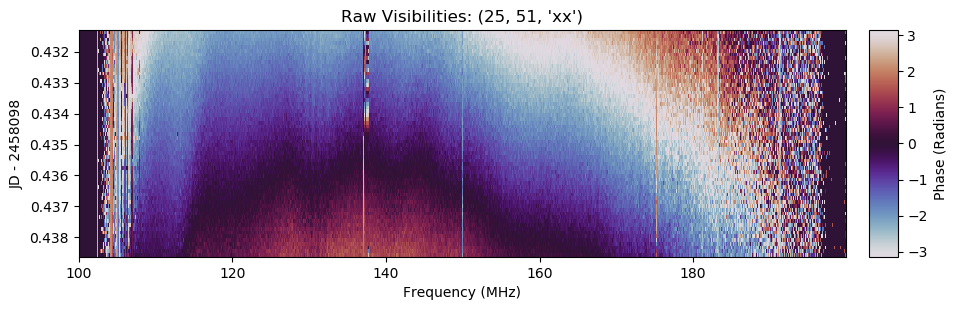

In [90]:
plt.figure(figsize=(12,3), dpi=100)
plt.imshow(np.angle(data[bl]) / (~flags[bl]), aspect='auto', cmap='twilight',
           extent=[hd.freqs[0]/1e6, hd.freqs[-1]/1e6, hd.times[-1]-2458098, hd.times[0]-2458098])
plt.ylabel('JD - 2458098')
plt.xlabel('Frequency (MHz)')
plt.title('Raw Visibilities: ' + str(bl))
plt.colorbar(label='Phase (Radians)', aspect=8, pad=.025);

## Array and Bad Antennas

The data taken for IDR2.1 began on 2458098 and ended on 2458116 with 52 antennas (~45 functional). Bad antennas, as determined by the commissioning team, are summarized in this folder:

In [91]:
bad_ants_folder = '/users/heramgr/hera_software/hera_opm/pipelines/h1c/idr2/v2/bad_ants/'
bad_ants = np.loadtxt(os.path.join(bad_ants_folder, '2458098.txt')).astype(int)
print('Bad antennas on 2458098:', bad_ants)

Bad antennas on 2458098: [  0   2  50  54  98 136 139]


We can visualize the array on 2458098 as follows:

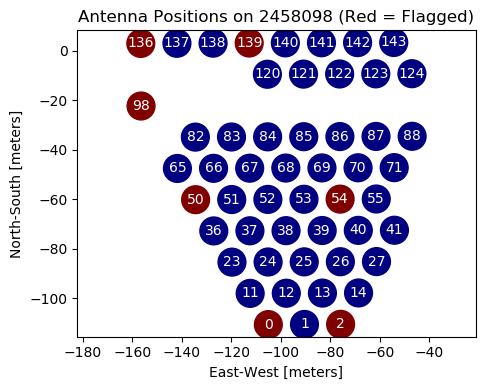

In [92]:
plt.figure(figsize=(5,4), dpi=100)
plt.scatter(np.array(list(hd.antpos.values()))[:,0], np.array(list(hd.antpos.values()))[:,1], 
            c=[ant in bad_ants for ant in hd.antpos.keys()], s=400, cmap='jet')
for ant,pos in hd.antpos.items():
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='w')
plt.xlabel("East-West [meters]")
plt.ylabel("North-South [meters]")
plt.title('Antenna Positions on 2458098 (Red = Flagged)');
plt.axis('equal')
plt.tight_layout()

All data in this IDR come from antennas in the Southwest sector of the split HERA core.

Additionally, we inherit antenna metrics from the commissioning team. These come in json files with the format `zen.2458098.43124.HH.uv.ant_metrics.json`. These can be read `hera_qm.ant_metrics.load_antenna_metrics()`.

The list of bad antennas generated by `ant_metrics` is generally a subset of the flagged antennas, but both are ORed together on a file-by-file basis. These antennas are left in all data/calibration files, but their flag arrays are all `True`.

## Pipeline Overview

The IDR 2.2 pipeline was run using [hera_opm](https://github.com/HERA-Team/hera_opm), which interfaces with the [Makeflow Workflow System](http://ccl.cse.nd.edu/software/makeflow/). The configuration files with the specific parameters used, associated bash scripts, and other files related bad antennas [can all be found here.](https://github.com/HERA-Team/hera_opm/tree/master/pipelines/h1c/idr2/v2)

Below is a flowchart (which also lives in `hera_opm`) detailing all the analysis steps in IDR 2.2, including the interdependencies of the pipeline and the outputs at various steps.

In [93]:
from IPython.display import IFrame
IFrame('https://nbviewer.jupyter.org/github/HERA-Team/hera_opm/blob/' +
     'master/pipelines/h1c/idr2/v2/Analysis_Flowchart.pdf', 980, 1450)

## Mainline Day-by-Day Data Products

The mainline daily analysis pipeline includes several steps of calibration, RFI-flagging, and an optional delay-filtering step. 

### Redcal: Redundant-Baseline Calibration

Redundant-baseline calibration solves for antenna gains and visibility solutions in order to minimize the difference between the observations and the model visibilities, expressed in terms of $\chi^2$:

$\chi^2(t,\nu) = \sum_{i,j} [V_{ij}^\text{obs}(t,\nu) - g_i(t,\nu) g_j^*(t,\nu) V_{i-j}^\text{sol}(t,\nu)] / \sigma^2_{ij}$.

The idea of redundant calibration is to solve for $g_i$ and $V_{ij}^\text{sol}$ simultaneously, taking advantage of the fact that there are far more total visibility measurements than unique baselines. This process takes place in three steps, `firstcal`, `logcal`, and `lincal` which iteratively searches for the minimum value of $\chi^2$ by first restricting degrees of freedom (`firstcal` finds one delay and one phase offset per antenna), finding an approximate per-frequency calibration solution with `logcal`, and then refining that solution with `lincal`. 

This procedure operates on `xx` and `yy` visibilities independently, cross-polarized visibilities are not used. Each time, frequency, and polarization has four degeneracies that cannot be solved for with redundant calibration (because they do not affect $\chi^2$):
* Overall amplitude
* Overall phase
* North-South phase gradient
* East-West phase gradient

For a more detailed, pedagogical explanation of the degeneracies of redundant-baseline calibration, see [Section 2 of this paper.](https://arxiv.org/abs/1712.07212). A thorough overview of the results from redundant calibration of HERA data in IDR 2.2 is forthcoming in Dillon et al. *(in prep.)*.

**New in IDR 2.2:** 
* `firstcal` has been rewritten to use the `linsolve` package and to iteratively solve for phase offsets (as opposed to just delays).  
* `lincal` is no longer uses the `omnical` package but rather a pure python implementation of it in `hera_cal.redcal`, which is both faster and more accurate (see [HERA Memo #50](http://reionization.org/wp-content/uploads/2013/03/HERA_memo050_Omnical-Convergence.pdf)). 
* $\chi^2 / DoF$ is now properly normalized (see [HERA Memo #61](http://reionization.org/wp-content/uploads/2019/01/HERA061_Omnical_Chisq_per_DoF.pdf)). 

As the above diagram indicates, the output of redundant calibration includes `firstcal` calibration solutions, `omnical` calibration solutions, and `omnical` visibility solutions for unique baselines.  The latter is output as a `.uvh5` file, albeit with fewer baselines than the full data (only one per unique separation). The first two are saved as `.calfits` files. Calibration solution in `.calfits` files can be read with `pyuvdata` or using the `HERACal` subclass in an analogous way to `HERAData`. `HERACal`'s `.read()` function returns gains, flags, and $\chi^2$ per antenna, and overall $\chi^2$. In the `omnical` calibration solutions, that $\chi^2$ is a properly normalized $\chi^2/DOF$.

In [94]:
from hera_cal.io import HERACal
from hera_cal.utils import split_bl
ant = split_bl(bl)[0]

# load firstcal gains and flags
firstcal_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.first.calfits')
hc = HERACal(firstcal_file)
fc_gains, fc_flags, _, _ = hc.read()

# load redundant calibration gains, flags, chi^2 per antenna, and chi^2 / DoF
omnical_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.omni.calfits')
hc = HERACal(omnical_file)
oc_gains, oc_flags, oc_quals, oc_total_quals = hc.read()

In [95]:
def waterfall_column(waterfalls, flags, titles, clims=None, clabels=None, cmaps=None, ylims=None, 
                     ylabel='JD - 2458098', extents=None, hspace=.1, figsize=(12,6), dpi=100):
    '''Useful plotting function for the IDR 2.2 memo.'''
    if clims is None:
        clims = [None for i in range(len(waterfalls))]
    if clabels is None:
        clabels = [None for i in range(len(waterfalls))]
    if cmaps is None:
        cmaps = [None for i in range(len(waterfalls))]
    if ylims is None:
        ylims = [None for i in range(len(waterfalls))]
    if not any(isinstance(ex, list) for ex in extents):
        extents = [extents for i in range(len(waterfalls))]

    fig, axes = plt.subplots(len(waterfalls), 1, sharex=True, squeeze=True, figsize=figsize, dpi=dpi)
    plt.subplots_adjust(hspace=hspace)
    for ax, wf, f, t, clim, clabel, cmap, ylim, ex in zip(axes, waterfalls, flags, titles,
                                                          clims, clabels, cmaps, ylims, extents):
        with np.errstate(divide='ignore', invalid='ignore'):
            im = ax.imshow(wf / ~f, aspect='auto', extent=ex, cmap=cmap)
        plt.colorbar(im, ax=ax, label=clabel, aspect=8, pad=.025)
        if ax == axes[-1]:
            ax.set_xlabel('Frequency (MHz)')    
        im.set_clim(clim)
        ax.set_ylabel(ylabel)
        ax.set_ylim(ylim)
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.02, 0.9, t, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

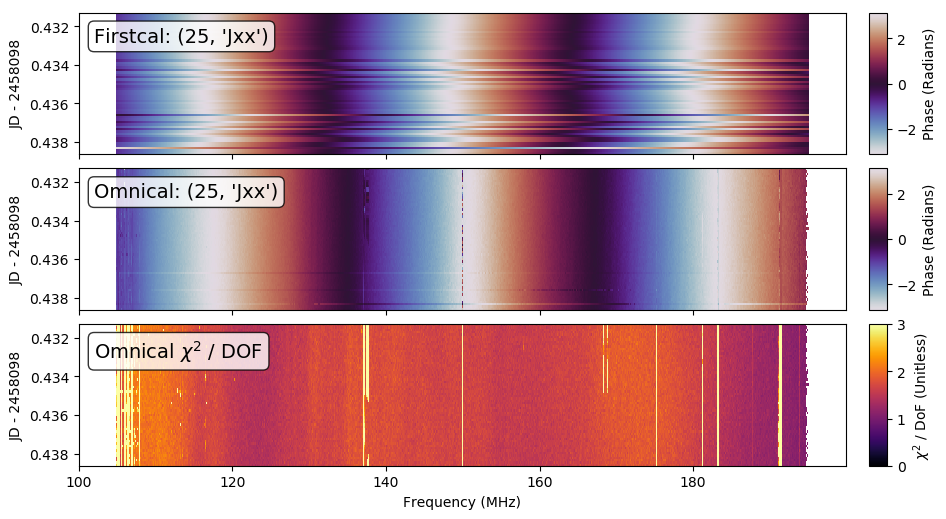

In [96]:
waterfall_column([np.angle(fc_gains[ant]), np.angle(oc_gains[ant]), oc_total_quals[ant[1]]],
                 [fc_flags[ant], oc_flags[ant], oc_flags[ant]],
                 ['Firstcal: {}'.format(ant), 'Omnical: {}'.format(ant), 'Omnical $\chi^2$ / DOF'],
                 clims=[None, None, [0, 3]],
                 clabels=['Phase (Radians)', 'Phase (Radians)', '$\chi^2$ / DoF (Unitless)'],
                 cmaps = ['twilight', 'twilight', 'inferno'],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] - 2458098, hc.times[0] - 2458098])

Here we see redundant baseline calibration solutions, which are dominated by an overall delay. We also see that $\chi^2 / DoF$ is generically greater than 1, indicating non-redundancy that seems to vary both in frequency and time. We also see clear evidence of narrow-band RFI which has not yet been excised. The first and last 50 channels were flagged by hand, a few more channels also got flagged at the high end of the band for producing `nan`s in the calibration solution, which usually occurs when there are 0s in the data. At this stage, we also flag any data where the sun is above the horizon, which explains why the IDR contains many completely flagged files.

Next, we compare redundantly calibrated data to the visibility solution for all redundant baselines in the same group. To do that, we use `hera_cal.apply_cal.calibrate_in_place()` to calibrate the data we've already loaded above and we use `hera_cal.redcal.get_reds()` to convert antenna positions into a list of redundant baseline groups, which are themselves lists of baselines. The first baseline in the group is used as the key in the omnical visibility solution.

In [97]:
# apply calibration solution to data
from copy import deepcopy
from hera_cal.apply_cal import calibrate_in_place
redcal_data, redcal_flags = deepcopy(data), deepcopy(flags)
calibrate_in_place(redcal_data, oc_gains, data_flags=redcal_flags, cal_flags=oc_flags)

In [98]:
# find the mapping of baselines to the unique baseline key used in the omnical visibility solutions 
from hera_cal.redcal import get_reds
reds = get_reds(hd.antpos)
red_dict = {bl: bl_group[0] for bl_group in reds for bl in bl_group} 
omnical_vis_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.omni_vis.uvh5')
hd_oc = HERAData(omnical_vis_file)
omnivis, omnivis_flags, _ = hd_oc.read(bls=[red_dict[bl]]) # note, this only has the first baseline in each redundant group

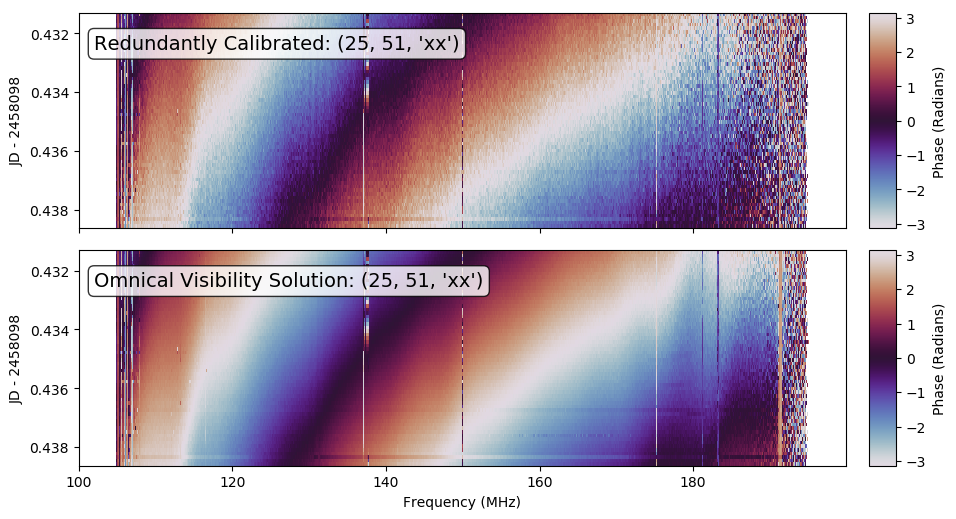

In [99]:
waterfall_column([np.angle(redcal_data[bl]), np.angle(omnivis[red_dict[bl]])],
                 [redcal_flags[bl], omnivis_flags[red_dict[bl]]],
                 ['Redundantly Calibrated: {}'.format(bl), 'Omnical Visibility Solution: {}'.format(bl)],
                 clabels=['Phase (Radians)', 'Phase (Radians)'],
                 cmaps = ['twilight', 'twilight'],                 
                 extents=[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.times[-1] - 2458098, hd.times[0] - 2458098])

Much of the difference between the individual calibrated visibility and the visibility solution is noise; the visibility solution is approximately equal to the average of all redundant baselines in a group.

### Abscal: Fixing Redcal Degeneracies with Externally Calibrated Visibilities

The next step in calibration is absolute calibration or `abscal`. Absolute calibration attaches the `omnical` gain solutions to a sky reference, allowing us to fix the degeneracies. In fact, absolute calibration is restricted to only modify the degenerate subspace of the omnical solutions; only four degrees of freedom per polarization per time per frequency are allowed to be modified.

Instead of using a point source model, `abscal` takes as its input a set of externally calibrated visibilities which we call the "abscal model," though simulated visibilities could also work. Individual integrations in the model are phased to match the nearest integration in the data. As in redundant calibration, `abscal` first calibrates a delay and phase slope across the array (a subset of the degeneracies) before solving for the degeneracies directly, namely a per-frequency and per-time phase slope and amplitude. 

The overall phase degeneracy cannot be solved by `abscal` because it has no impact on calibrated visibilities. To resolve it, we pick a reference antenna and rephase all other gains so that it has zero phase for all frequencies and times. We choose a reference antenna per-file and per-polarization reference antenna that 1) has no more flags than any other antenna and 2) introduces the least phase noise into the other gains. Later in the calibration smoothing step, we will rephase to a single reference antenna for the whole night using the same criteria. 

Because polarizations are calibrated separately without reference to any $xy$- or $yx$-visibilities, we have no reason to expect that the cross-polarized visibilties are properly calibrated. This does not affect our analysis of psuedo-Stokes I or Q images or power spectra, but it does mean that our pseudo-Stokes U and V images and power spectra are not reliable at this point.

**New in IDR 2.2**:

In IDR 2.2, we added a notion of `abscal` $\chi^2$, defined as:

$\chi^2_\text{abs}(t,\nu) = \sum_{i,j} [V_{ij}^\text{model}(t,\nu) - g^\text{abs}_i(t,\nu) g^{*\text{abs}}_j(t,\nu) V_{i,j}^\text{raw}(t,\nu)] / \sigma^2_{ij}$,

where $\sigma^2$ is the noise on the absolute calibrated visibilities (as inferred from the autocorrelations). Unlike the `omnical` $\chi^2$, this is not properly normalized per DoF. However, it is still a useful metric of discrepancy between the data after `redcal` and `abscal` and the externally calibrated visibilities. 

For IDR2.2, the data was calibrated by looking at three days that span the LST range of what will eventually be H1C IDR3, namely 2458042, 2458116, and 2458161. Each day was calibrated in CASA using a different calibrator field from [GLEAM](http://www.mwatelescope.org/gleam) and only baselines > 40 m in length:
* 2458042 was calibrated on a field centered at 2.0167 hours of LST (including GLEAM J0200-3053)
* 2458116 was calibrated on a field centered at 5.2367 hours of LST (including GLEAM J0513-3028)
* 2458161 was calibrated on a field centered at 14.4428 hours of LST (including GLEAM J1425-2959)

The calibration solutions were assumed to be stable over the course of each calibration day. Then, to form one synthetic day externally calibrated visibilities, these days are "cross-faded" into each other, effectively a weighted average of the three days with weights that fall linearly away from the calibration field and are 0 when the sun is up. 

Finally, the abscal model was low-pass delay filtered (using a [Tukey window](https://en.wikipedia.org/wiki/Window_function#Tukey_window) with $\alpha=0.2$) at either the baseline's horizon + 50 ns, or 150 ns, whichever is longer. This lowered the noise on the model, removed any high-frequency spectral structure we don't expect to be associated with the sky, and allowed interpolation over RFI-contaminated channels. Unfortunately, this also risks spreading out any isolated but unflagged RFI, which we see some evidence of in the the abscal $\chi^2$ below. 

For more on absolute calibration, see [HERA Memo #42](http://reionization.org/wp-content/uploads/2013/03/abscal_memo.pdf) for the IDR 2.1 implementation or Kern et al. *(in prep.)*.

In [100]:
# Load abscal calibration solutions
abscal_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.abs.calfits')
hc = HERACal(abscal_file)
ac_gains, ac_flags, ac_quals, ac_total_quals = hc.read()

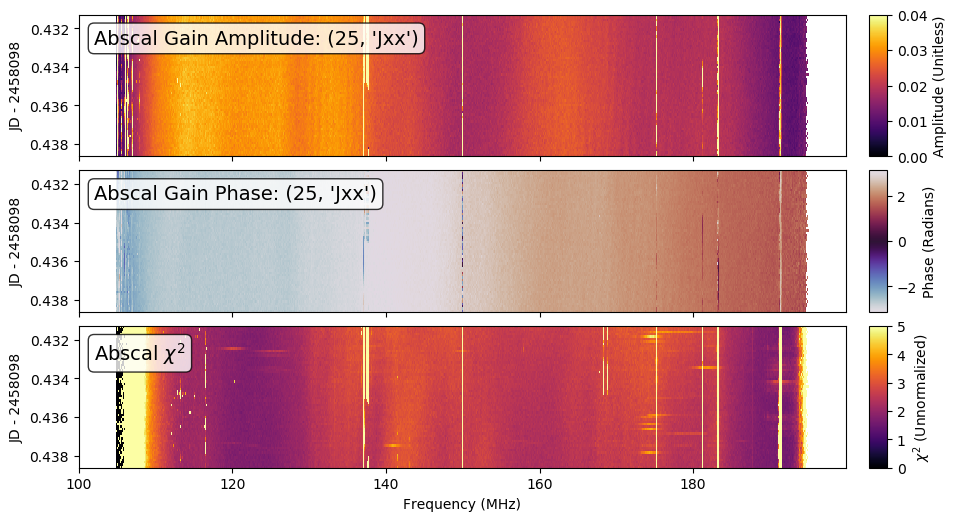

In [101]:
waterfall_column([np.abs(ac_gains[ant]), np.angle(ac_gains[ant]), ac_total_quals[ant[1]]],
                 [ac_flags[ant], ac_flags[ant], ac_flags[ant]],
                 ['Abscal Gain Amplitude: {}'.format(ant), 'Abscal Gain Phase: {}'.format(ant), 'Abscal $\chi^2$'],
                 clims=[[0, .04], None, [0, 5]],
                 clabels=['Amplitude (Unitless)', 'Phase (Radians)', '$\chi^2$ (Unnormalized)'],
                 cmaps = ['inferno', 'twilight', 'inferno'],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] - 2458098, hc.times[0] - 2458098])

We can also see that the absolutely calibrated data now closely matches the reference at the same LSTs.

In [102]:
# Apply abscal calibration to data
abscal_data, abscal_flags = deepcopy(data), deepcopy(flags)
calibrate_in_place(abscal_data, ac_gains, data_flags=abscal_flags, cal_flags=ac_flags)

In [103]:
# Find corresponding LSTs in the externally calibrated Abscal Model
from hera_cal.abscal import match_times
model_files = glob.glob('/lustre/aoc/projects/hera/nkern/idr3_abscal_models/full_model/' +
                        'zen.2458042.58*.HH.uvRXLS.uvh5') # cheatingly slightly by only checking the .58* files
matched_model_files = sorted(set(match_times(sample_data_file, model_files, filetype='uvh5')))
hdm = HERAData(matched_model_files)
model, model_flags, _ = hdm.read(bls=[bl])

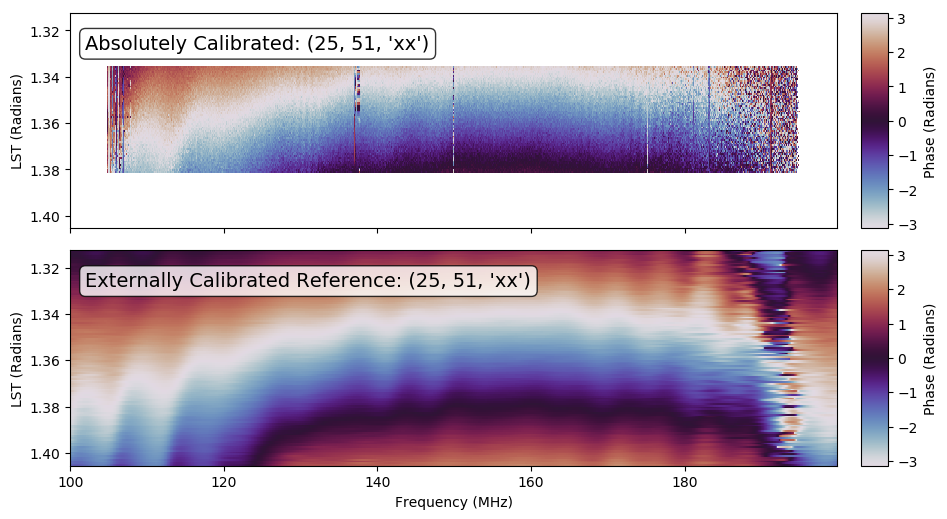

In [104]:
# compare redundantly and then absolutely calibrated data to externally calibrated reference
waterfall_column([np.angle(abscal_data[bl]), np.angle(model[bl])],
                 [abscal_flags[bl], model_flags[bl]],
                 ['Absolutely Calibrated: {}'.format(bl), 'Externally Calibrated Reference: {}'.format(bl)],
                 clabels=['Phase (Radians)', 'Phase (Radians)'],
                 ylabel='LST (Radians)',
                 cmaps = ['twilight', 'twilight'],                 
                 ylims = [[model.lsts[-1], model.lsts[0]], None],                 
                 extents=[[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.lsts[-1], hd.lsts[0]], 
                          [model.freqs[0] / 1e6, model.freqs[-1] / 1e6, model.lsts[-1], model.lsts[0]]])

### RFI Flagging

Our Radio Frequency Interference (RFI) flagging algorithm has largely been overhauled for IDR2.2, though it still relies fundamentally on the basic idea of looking for highly-significant outliers in detrended data and then also flagging less significant outliers that neighbor them in time or frequency, the so-called "watershed" algorithm. This relies on the idea that RFI events are compact in frequency or time or both.

**New in IDR 2.2:**

The following algorithm is used for RFI flagging on a per-observation basis.

1. *Compute metric waterfalls of calibration data products using median filters.* We begin by flagging on the `omnical` gains, `omnical` $\chi^2/DoF$, the `omnical` visibility solutions, the `abscal` gains, and the `abscal` $\chi^2$. Each baseline, antenna, or polarization's waterfall is median filtered (i.e. the local median subtracted off in a 8 integration by 8 channel box) and each each data point is compared to the local median and median absolute deviation to compute a metric of "outlierness" in number of $\sigma$s. These "metrics" are averaged in quadrature to produce a single waterfall for each data product. 


2. *Flag and watershed on metrics waterfalls individually and collectively to produce a set of initial flags.* $5\sigma$ outliers on each waterfall are flagged, and then any $2\sigma$ outliers that neighbor a flag are also flagged. This process is performed both on individual calibration data products to look for specific issues with the associated step, and then on a equally-weighted average in quadrature of all 5 waterfalls to look for low level RFI. These are all ORed together to produce an initial set of flags.


3. *Use the initial flags to compute metric waterfalls of both calibration products and raw data using mean filters.* The process is repeated on the five calibration data products above, but now also on the raw data itself (these were excluded from the first step because they are slow to work with). However, because the data now already have flags, we use a *mean* filter instead of a median filter, which can better handle setting the weight of flagged data to zero. Since the data are already pre-flagged, the worst outliers that would throw off this calculation are already gone. This is effectively computing a number of $\sigma$s for each time and frequency in terms of a weighted local standard deviation. These are then averaged in quadrature to form metrics waterfalls. 


4. *Flag and watershed on new metrics waterfalls individually and collectively and OR those flags with the initial flags.*  Once again, we look for significant outliers ($> 5\sigma$) and minor neighboring outliers ($> 2\sigma$) and flag both on individual metrics waterfalls and on the quadrature average of all six waterfalls. All the resulting flags are ORed together with the initial flags. 


5. *Threshold and broadcast flags across frequency and time.* For each channel, flag all times if more than 35% of times are flagged for that channel. Independently, for each time, flag all channels if more than 50% of channels are flagged. The calculation of these percentages excludes individual times and frequencies that were part of a completely flagged time or a completely flagged channel. (Note that `smooth_cal` below also has somewhat more aggressive thresholding and broadcasting step.)


6. *Update and save flags in updated `.flagged_abs.calfits` file and save various intermediate metrics and flagging products as HDF5 files (readable with `pyuvdata.UVFlag`).*

In [105]:
# load flagged calibration solutions
flagged_abscal_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.flagged_abs.calfits')
hc = HERACal(flagged_abscal_file)
fac_gains, fac_flags, fac_quals, fac_total_quals = hc.read()

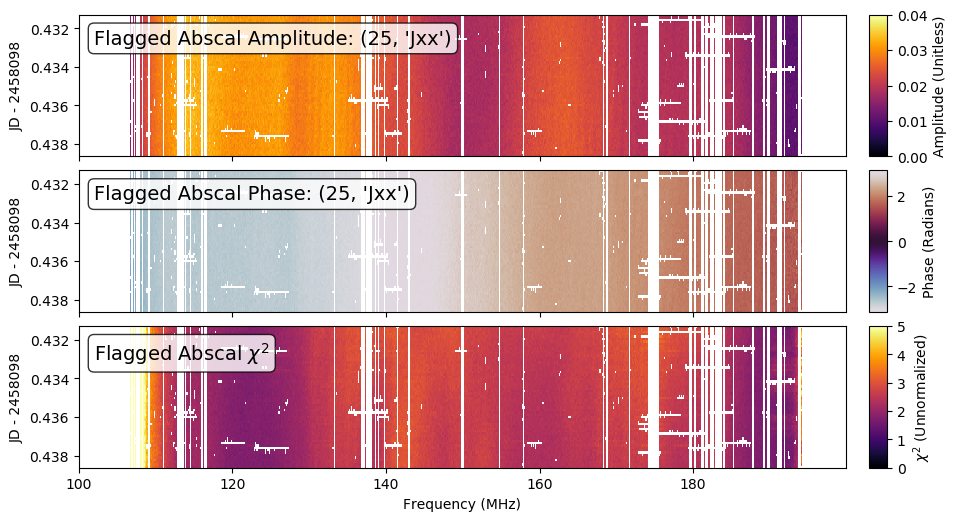

In [106]:
waterfall_column([np.abs(fac_gains[ant]), np.angle(fac_gains[ant]), fac_total_quals[ant[1]]],
                 [fac_flags[ant], fac_flags[ant], fac_flags[ant]],
                 ['Flagged Abscal Amplitude: {}'.format(ant), 
                  'Flagged Abscal Phase: {}'.format(ant), 
                  'Flagged Abscal $\chi^2$'],
                 clims=[[0, .04], None, [0, 5]],
                 clabels=['Amplitude (Unitless)', 'Phase (Radians)', '$\chi^2$ (Unnormalized)'],
                 cmaps = ['inferno', 'twilight', 'inferno'],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] - 2458098, hc.times[0] - 2458098])

This algorithm seems to catch all obvious RFI and also flags the impact of RFI in the `abscal` model (as seen in the `abscal` $\chi^2$).

### Calibration Smoothing

To reduce the number of degrees of freedom in the calibration solution, we rely on the assumption that the instrument does not have spectral structure on small frequency scales and that it does not evolve quickly in time. Our smoothing algorithm loads in a whole day of calibration solutions simultaneously and put them on a time grid, leaving flagged holes for any missing files or missing time.

**New in IDR 2.2:**

Most notably, we have implemented 2D smoothing. In IDR 2.1, we smoothed in time and then in frequency. Here we do both simultaneously using a 2D CLEANing algorithm. We restrict our CLEANed solution in delay/fringe-rate space,  filtering on 10 MHz (i.e. 100 ns) and 30 minute (0.556 mHz) scales. This filtering is done with a Tukey window with $\alpha = .5$ in frequency and a top-hat window in time.

The calibration smoothing step is also the first step during which all the per-antenna flags for a given day are in memory at the same time. Therefore we impose an additional, somewhat more stringent round of flag thresholding and broadcasting. The procedure is as follows:

1. Figure out the times and frequencies that are flagged for all antennas.
2. For each channel, figure out the fraction of times during the day that it's flagged, not counting times that are also flagged for all channels. If it's greater than 0.35, flag the whole channel. 
3. For each time, figure out the fraction of channels that it's flagged, not counting channels that are also flagged for all times during the day. If it's greater than 0.5, flag the whole time.
4. Repeat steps 2 and 3 until no new flags are produced.
5. Count the number of unflagged visibilities on each antenna. Any antenna with less than 50% of the maximum among all antennas is also flagged. 

Here is an example of a calibration smoothing in action: 

In [107]:
smoothed_abscal_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.smooth_abs.calfits')
hc = HERACal(smoothed_abscal_file)
sac_gains, sac_flags, _, _ = hc.read()

In [108]:
# find antenna that was picked as the reference by looking for unflagged antennas with 0 phase
sc_refant = {pol: sorted([(np.mean(np.abs(np.angle(sac_gains[ant]))), ant) 
                          for ant in sac_gains if ant[1]==pol and not np.all(sac_flags[ant])])[0][1]
                          for pol in hc.pols}
for pol in hc.pols:
    print('Antenna {} chosen as the reference for {}.'.format(sc_refant[pol][0], pol))

Antenna 39 chosen as the reference for Jxx.
Antenna 121 chosen as the reference for Jyy.


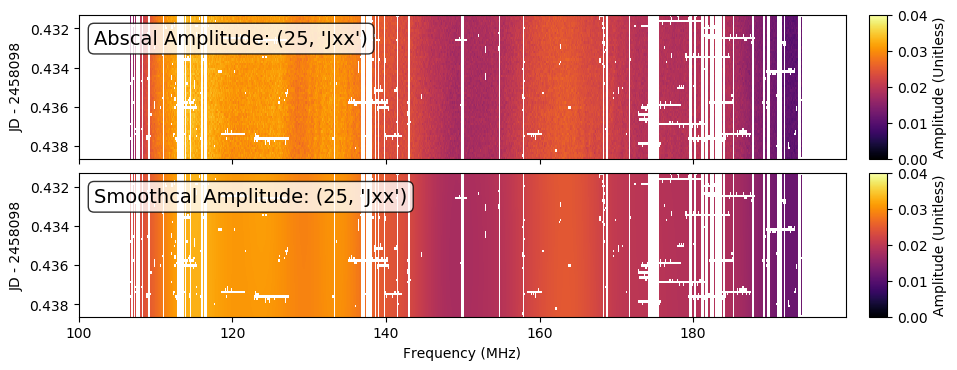

In [109]:
# rephase abscal to to have the same reference antenna as smooth_cal
rephased_abscal = fac_gains[ant] * np.abs(fac_gains[sc_refant[ant[1]]]) / fac_gains[sc_refant[ant[1]]]
smoothcal_gains = deepcopy(sac_gains[ant])

waterfall_column([np.abs(rephased_abscal), np.abs(smoothcal_gains)],
                 [fac_flags[ant], sac_flags[ant]],
                 ['Abscal Amplitude: {}'.format(ant), 'Smoothcal Amplitude: {}'.format(ant)],
                 clabels=['Amplitude (Unitless)', 'Amplitude (Unitless)'],
                 cmaps = ['inferno', 'inferno'],
                 figsize=(12,4),
                 clims=[[0, .04], [0, .04]],
                 extents=[hc.freqs[0] / 1e6, hc.freqs[-1] / 1e6, hc.times[-1] - 2458098, hc.times[0] - 2458098])

All-NaN slice encountered


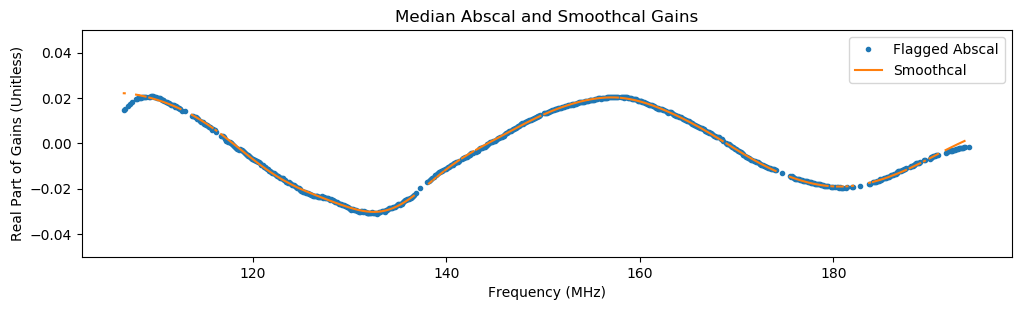

In [110]:
# replace flags with nans in order to take a nanmedian over time
rephased_abscal[fac_flags[ant]] = np.nan
smoothcal_gains[sac_flags[ant]] = np.nan

# plot median smooth calibration
plt.figure(figsize=(12,3), dpi=100)
plt.plot(hc.freqs / 1e6, np.nanmedian(rephased_abscal, axis=0).real, '.', label='Flagged Abscal')
plt.plot(hc.freqs / 1e6, np.nanmedian(smoothcal_gains, axis=0).real, label='Smoothcal')
plt.title('Median Abscal and Smoothcal Gains')
plt.ylabel('Real Part of Gains (Unitless)')
plt.xlabel('Frequency (MHz)')
plt.ylim(-.05, .05)
plt.legend();

### Delay Filter

At this point in the pipeline, we are ready to LST-bin our calibrated data. However, we produce calibrated and delay-filtered data. These files, the `.OCRSD.uvh5` files are the only full-sized data files produced before LST-binning. `OCRSD` is a legacy nomenclature meaning <b>O</b>micaled, abs<b>C</b>aled, x<b>R</b>fi, <b>S</b>moothcaled, <b>D</b>elay-filtered data. 

Delay filtering is performed independently for each integration and each baseline in the calibrated and flagged data. Delay filtering removes Fourier content outside the baseline's horizon delay, plus a 15 ns buffer. To account for RFI gaps, it is done using the CLEAN algorithm with a $10^{-9}$ tolerance and a Tukey window with $\alpha=0.5$. 

This procedure is largely the same as in IDR2.2 (the only significant update was improved memory management using partial I/O enabled by `.uvh5`).

In [111]:
delay_filtered_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.OCRSD.uvh5')
hd_dfil = HERAData(delay_filtered_file)
dfil_data, dfil_flags, _ = hd_dfil.read(bls=[bl])

In [112]:
# Apply abscal calibration to data
sac_data, sac_data_flags = deepcopy(data), deepcopy(flags)
calibrate_in_place(sac_data, sac_gains, data_flags=sac_data_flags, cal_flags=sac_flags)

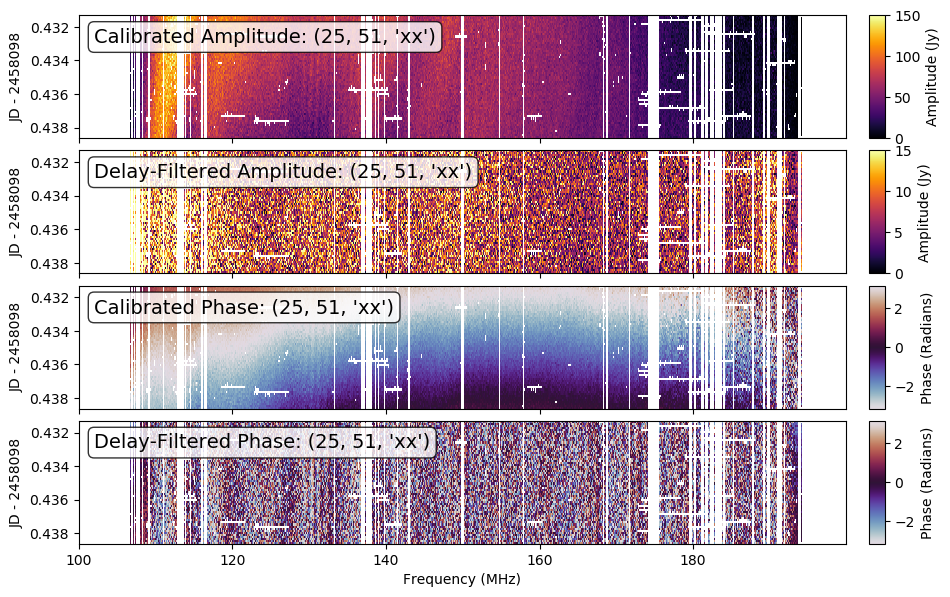

In [113]:
waterfall_column([np.abs(sac_data[bl]), np.abs(dfil_data[bl]), np.angle(sac_data[bl]), np.angle(dfil_data[bl])],
                 [sac_data_flags[bl], dfil_flags[bl], sac_data_flags[bl], dfil_flags[bl]],
                 ['Calibrated Amplitude: {}'.format(bl), 'Delay-Filtered Amplitude: {}'.format(bl),
                 'Calibrated Phase: {}'.format(bl), 'Delay-Filtered Phase: {}'.format(bl)],
                 clabels=['Amplitude (Jy)', 'Amplitude (Jy)', 'Phase (Radians)', 'Phase (Radians)'],
                 clims=[[0, 150], [0, 15], None, None],
                 cmaps = ['inferno', 'inferno', 'twilight', 'twilight'],
                 extents=[hd_dfil.freqs[0] / 1e6, hd_dfil.freqs[-1] / 1e6, 
                          hd_dfil.times[-1] - 2458098, hd_dfil.times[0] - 2458098],
                 figsize=(12,7))

(Note the different color scale on the delay-filtered amplitude.)

While the delay filter vastly reduces the amplitude of the visibility to much closer to the noise level , the result is not purely noise-like, as can be seen in the spectral structure in the delay-filtered phase. This may be, in part, due to some of the non-fringing structure examined in the two Kern et al. (*submitted*/*in prep.*) examining systematics.

## Ancillary Day-by-Day Data Products

The main goal of analysis is to calibrate and RFI-flag to as to enable LST-binning and the resultant reduction in data volume. However, we perform several additional steps that produce useful data products for quality assessment of the data and various open research questions.

### Raw Autocorrelations and Noise

**New in IDR 2.2:**

To enable future calibration tests, the pipeline extracts autocorrelations. While in principle this is duplicating data and is otherwise trivial with partial I/O, this step anticipates IDR 3.1 and beyond where we cannot keep the full data set staged on `lustre`. For future tests of calirabtion and noise, it [was requested](https://github.com/HERA-Team/hera_cal/issues/405) to store these raw data products alongside calibration solutions. These autocorrelations are stored in `.autos.uvh5` and only have autocorrelation baseline keys.

Using calibrated autocorrelations, we can predict the noise variance on visibilities, $\sigma_{ij}^2$. Namely,

$\sigma_{ij}^2 = V_{ii} V_{jj}$ $ / $ $B t$

where $B$ is the bandwidth of a channel and $t$ is the integration time. Instead of computing this quantity for all baselines, we instead compute and save $\sigma_{ii}$ where

$\sigma_{ij} \equiv \sqrt{\sigma_{ii} \sigma_{jj}} = \left(V_{ii} / \sqrt{Bt}\right) \left( V_{jj} / \sqrt{Bt} \right)$.

These quantities, $\sigma_{ii}$, are stored in `.noise_std.uvh5` files. Though they are technically per-antenna, we felt it more sensible to store them as visibility data files (since the units are Jy) with autocorrelation keys instead of storing them in `.calfits` files.

In [114]:
from hera_cal.utils import join_bl
ant1, ant2 = split_bl(bl)
auto_bl1 = join_bl(ant1, ant1)
auto_bl2 = join_bl(ant2, ant2)

# Load autocorrelation
autos_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.autos.uvh5')
hd_autos = HERAData(autos_file)
autos, auto_flags, _  = hd_autos.read(bls=[auto_bl1, auto_bl2])

# Calibrate autocorrelation
cal_autos, cal_auto_flags = deepcopy(autos), deepcopy(auto_flags)
calibrate_in_place(cal_autos, sac_gains, data_flags=cal_auto_flags, cal_flags=sac_flags)

# Load inferred noise on calibrated data
noise_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.noise_std.uvh5')
hd_noise = HERAData(noise_file)
noise, noise_flags, _  = hd_noise.read(bls=[auto_bl1, auto_bl2])
bl_noise = np.sqrt(noise[auto_bl1] * noise[auto_bl2])

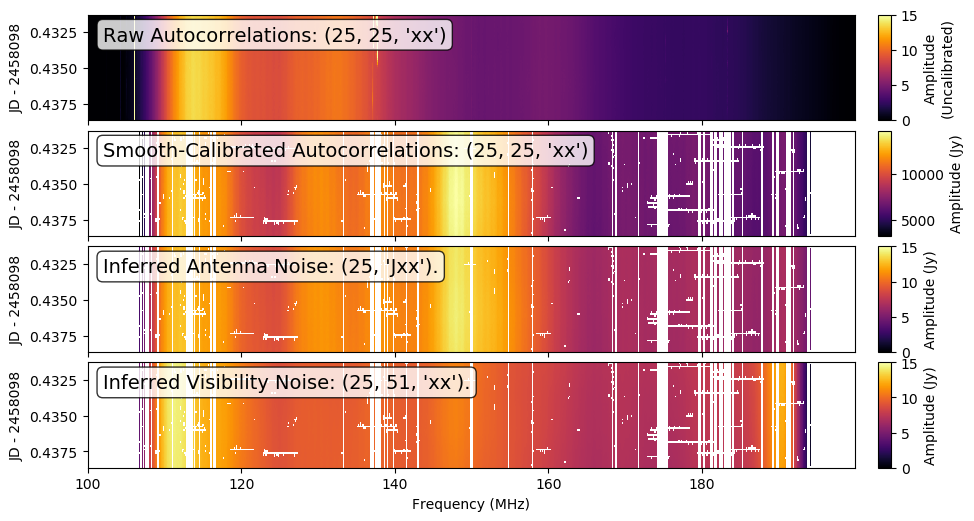

In [115]:
waterfall_column([np.abs(autos[auto_bl1]), np.abs(cal_autos[auto_bl1]), 
                  np.abs(noise[auto_bl1]), np.abs(bl_noise)],
                 [auto_flags[auto_bl1], cal_auto_flags[auto_bl1], 
                  noise_flags[auto_bl1], noise_flags[auto_bl1] | noise_flags[auto_bl2]],
                 ['Raw Autocorrelations: {}'.format(auto_bl1), 
                  'Smooth-Calibrated Autocorrelations: {}'.format(auto_bl1),
                  'Inferred Antenna Noise: {}.'.format(ant1),
                  'Inferred Visibility Noise: {}.'.format(bl)],
                 clabels=['Amplitude\n(Uncalibrated)', 'Amplitude (Jy)', 'Amplitude (Jy)', 'Amplitude (Jy)'],
                 clims=[[0, 15], None, [0,15], [0,15]],
                 cmaps = ['inferno', 'inferno', 'inferno', 'inferno'],
                 extents=[hd_autos.freqs[0] / 1e6, hd_autos.freqs[-1] / 1e6, 
                          hd_autos.times[-1] - 2458098, hd_autos.times[0] - 2458098],)

### Reflection Fitting

**New in IDR 2.2:**

Calibration smoothing erases small scale spectral structure in calibration solutions, some of which we believe is real. For example, we see clear evidence from the autocorrelations of ripples in the calibration solutions attributable to reflection systematics. An extra trip down and back up 150 m cables produce delays of 1250 ns, assuming a speed of light in the cables of $0.8c$. Such reflections were seen in every antenna at different delays and amplitudes in [HERA Memo #64](http://reionization.org/wp-content/uploads/2013/03/HERA064_reflection_memo.pdf).

In the two forthcoming Kern et al. papers on HERA systematics, we develop and test a method for mitigating these systematics by fitting the reflection in delay space and then running an iterative, non-linear optimizer to refine the estimate of the reflection delay, amplitude, and phase. 

In theory, the calibration solutions found for the cable reflections could be incorporated into the final, smoothed calibration solution by multiplying (an example of which we show below). In practice, we feel that this move is risky until the stability of the fits and of the cable reflections themselves are more thoroughly explored. Therefore, we provide calibration solutions of just cable reflections in `.reflections.calfits` files in order to support open research questions about these reflections.

In [116]:
reflections_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.reflections.calfits')
hc = HERACal(reflections_file)
rfl_gains, rfl_flags, _, _ = hc.read()

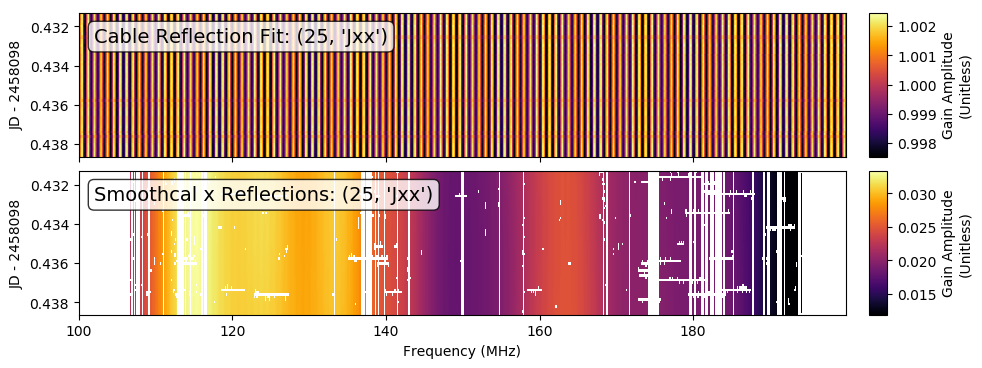

In [117]:
waterfall_column([np.abs(rfl_gains[ant]), np.abs(rfl_gains[ant] * sac_gains[ant])],
                 [rfl_flags[ant], sac_flags[ant]],
                 ['Cable Reflection Fit: {}'.format(ant), 'Smoothcal x Reflections: {}'.format(ant)],
                 clabels=['Gain Amplitude\n(Unitless)', 'Gain Amplitude\n(Unitless)'],
                 cmaps = ['inferno', 'inferno'],
                 extents=[hd.freqs[0] / 1e6, hd.freqs[-1] / 1e6, hd.times[-1] - 2458098, hd.times[0] - 2458098],
                 figsize=(12,4))

In [118]:
hd.freqs[150]/1e6, hd.freqs[900]/1e6

(114.6484375, 187.890625)

### Multi-Frequency Synthesis Imaging with CASA

**New in IDR 2.2:**

For this IDR, all files are also passed through a multi-frequency synthesis imagine routine in CASA. These images are largely for diagnostic purposes, they are not meant for direct comparison to external catalogs or for any sort of power spectrum analysis. We image both in instrumental polarizations, i.e. `xx` and `yy`, and in pseudo-Stokes I, Q, U, and V. The various imaging products are stored as `.fits` in the `*.calibrated.uvh5_image/` folder corresponding to each file. 

The image products are dirty images (no CLEANing has been done, i.e. `niter=0`) and are not primary-beam corrected. We use [Briggs weighting](https://casa.nrao.edu/Release3.3.0/docs/UserMan/UserMansu247.html) with `robust=0`. We synthesize the image using channels 150 to 900, corresponding to 114.6 - 187.9 MHz. The images are 512 by 512 pixels centered at zenith with 500 arcsecond pixels.

In [119]:
from astropy.io import fits
from astropy import wcs
from hera_cal.utils import polnum2str

In [123]:
image_fits = os.path.join(analysis_folder, '2458098/zen.2458098.41632.HH.calibrated.uvh5_image/' + 
                         'zen.2458098.41632.HH.calibrated.uvh5.image.image.fits')
hdulist = fits.open(image_fits)
coords = wcs.WCS(hdulist[0].header, naxis=[wcs.WCSSUB_CELESTIAL])

fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=100, subplot_kw={'projection': coords})
plt.subplots_adjust(hspace=0, wspace=.3)
for i, (ax, image_data) in enumerate(zip(np.ravel(axes), hdulist[0].data[:, 0, ...])):
    im = ax.imshow(image_data, cmap='inferno')
    ax.grid()
    ax.set_xlim([150, image_data.shape[0] - 150])
    ax.set_ylim([150, image_data.shape[1] - 150])
    pol = polnum2str(int(i * hdulist[0].header['CDELT4'] + hdulist[0].header['CRVAL4'])).replace('p', 'Pseudo-')
    plt.colorbar(im, ax=ax, label='Jy/Beam', fraction=0.046, pad=0.04)
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, 'Stokes ' + pol, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

FileNotFoundError: [Errno 2] No such file or directory: '/lustre/aoc/projects/hera/plaplant/H1C_IDR2/v2/2458098/zen.2458098.41632.HH.calibrated.uvh5_image/zen.2458098.41632.HH.calibrated.uvh5.image.image.fits'

TODO: Mention [Nick's memo](http://reionization.org/wp-content/uploads/2013/03/abscal_memo.pdf).

## LST-Binned Data Products

### LST-Binning

TODO!

OLD STUFF:


Both before and after delay filtering, the data is LST-binned into a single group, into two groups of interleaved nights, and into three groups of interleaved nights. During LST binning, each integration is assigned to the the nearest LST bin, but is rephased to account for the slight difference in LST between its bin center and the LST bin's center. LST bins were chosen to be twice as long as raw data bins (21.475 seconds = 0.00156597 radians of a sidreal day), so every LST bin gets two data points for every input night.

Next, the list of rephased data points that would go into any given LST and frequency bin are examined for outliers. For relatively robust outlier detection, we compute the [median absoute deviation (MAD)](https://en.wikipedia.org/wiki/Median_absolute_deviation) of all the points that are to be binned together and use that to compute a modified z-score. As long as there are at least 5 data points to bin together, we then flag all data that with a modified z-score greater than 5, which corresponds to $5\sigma$ outliers if the distribution were Gaussian.

Finally, we compute the standard deviation of both the real and imaginary parts of the unflagged data and store those in the `.STD.` file. We also save the number of samples that went into each binned data point in both the `.LST.` and `.STD.` files. We do not further perform a cut on the number of samples or any other form of post-LST binning RFI flagging. 


In [77]:
# TODO: show LST-binned data vs. 2458098
# TODO: Show sigma of binned visibilities, so noise from 2458098, show Nsamples

## Known Issues, Future Improvements, and Open Questions

* Abscal model flagging is imperfect
* Antennas flagged in abscal model flagged throughout the data
* Day long thresholding of RFI statistics
* Issues with `2458104.28210`, `2458104.28955`, and `2458109.32684`: these files failed on the delay filter, so I've gone in and flagged them by hand. 
* Reflections: are they stable?

* Move broadcasting over whole days back into hera_qm (and out of smooth_cal)

# Old Memo Content

## 4. LST-Binned Data Products

LST-binned HERA visibility data generally has the format `zen.grp1.of2.xx.LST.1.28828.uvOCRSL` which can be interpreted as:

* `zen`: zenith pointing
* `grp1`: 1-indexed group of nights that the LST binned data products are divided into
* `of2`: number of groups of nights that the data was divided into before separately LST-binning each group together
* `LST`: LST-binned data. The other alternative is `STD`, which encodes the standard deviation of the real and imaginary parts (separately) of the binned data in its real and imaginary data array
* `1.28828`: starting LST of the data in radians
* `uvOCRSL`: extension for calibrated, RFI-flagged, LST-binned data, but not delay-filtered. The LST-binned results also include `uvOCRSDL` files, which have been delay-filtered.  **L** is for **L**ST-binning.

In general, LST-binned data files are also 60 integrations, but each integration is 21.475 seconds, double the integration time of the raw data files. 

The data can be found in `/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/LSTBIN/{one/two/three}_group/grp{N}/`.

For the nights split into two groups, we have:
* grp1: 2458098, 2458101, 2458103, 2458105, 2458107, 2458109, 2458111, 2458113, 2458115
* grp2: 2458099, 2458102, 2458104, 2458106, 2458108, 2458110, 2458112, 2458114, 2458116

For the nights split into three groups, we have:
* grp1: 2458098, 2458102, 2458105, 2458108, 2458111, 2458114
* grp2: 2458099, 2458103, 2458106, 2458109, 2458112, 2458115
* grp3: 2458101, 2458104, 2458107, 2458110, 2458113, 2458116

The LST-binned data are also stored in the miriad format and accessible via `pyuvdata` or `hera_cal.io`:


In [21]:
lstbinned = os.path.join(analysis_folder,'LSTBIN/two_group/grp1/zen.grp1.of2.xx.LST.1.28828.uvOCRSL')
l_uvd = UVData()
l_uvd.read_miriad(lstbinned)
(l_data, l_flags, l_antpos, l_ants, l_freqs, l_times, l_lsts, l_pols) = io.load_vis(l_uvd, return_meta=True)

antenna_diameters is not set. Using known values for HERA.


divide by zero encountered in divide
invalid value encountered in divide


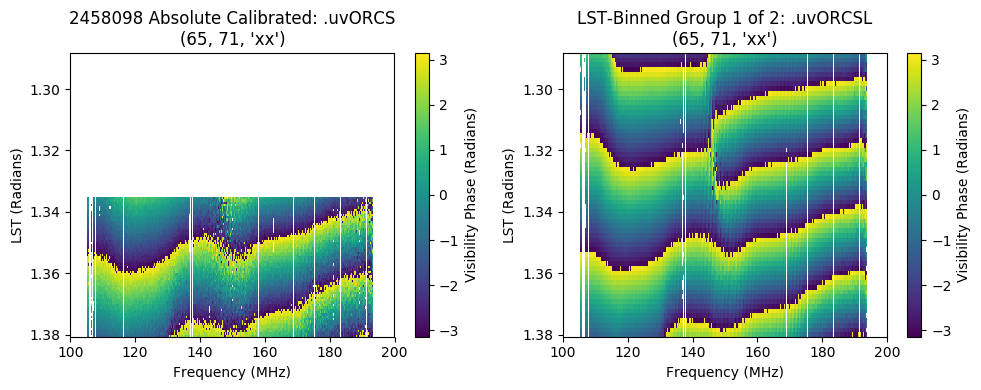

In [22]:
bl = (65,71,'xx')
plt.figure(figsize=(10,4), dpi=100)
for d, f, sub, l, t in zip([abscaled_data, l_data], [abscaled_flags, l_flags], 
                            [121, 122], [lsts, l_lsts],
                            ['2458098 Absolute Calibrated: .uvORCS', 'LST-Binned Group 1 of 2: .uvORCSL']): 
    plt.subplot(sub)
    plt.imshow(np.angle(d[bl]) / (~f[bl]), aspect='auto',
               extent=[freqs[0]/1e6,freqs[-1]/1e6,l[-1],l[0]])
    plt.title(t + '\n' + str(bl))
    plt.ylabel('LST (Radians)')
    plt.xlabel('Frequency (MHz)')
    plt.colorbar(label='Visibility Phase (Radians)');
    plt.ylim([l_lsts[-1],l_lsts[0]])
plt.tight_layout()    

Note that a single LST-binned data file covers twice as much time as a single data file because the integrations are twice as long. Note also that the LST-binned data will in general have fewer flags than the observation on a single night because LST-binned data is only flagged when all the input data is flagged. However, the statistics of the data are available in two places. The first is the standard deviations of the data that go into each LST bin. The standard deviations of the real and imaginary parts are computed separately and stored as the real and imaginary parts of the visibility data in the `zen.*.STD.*` files. Second is the `nsample_array` which is accessible through `pyuvdata` using `get_nsamples()`.

In [23]:
lst_stds, _ = io.load_vis(os.path.join(analysis_folder,'LSTBIN/two_group/grp1/zen.grp1.of2.xx.STD.1.28828.uvOCRSL'))

divide by zero encountered in divide


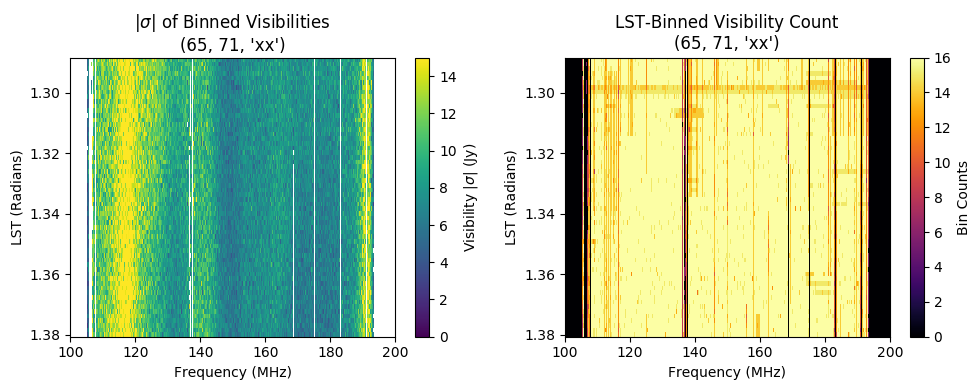

In [24]:
bl = (65,71,'xx')
nSamples = l_uvd.get_nsamples(bl)
plt.figure(figsize=(10,4), dpi=100)
plt.subplot(121)
plt.imshow(np.abs(lst_stds[bl]) / (~l_flags[bl]), aspect='auto',
           extent=[freqs[0]/1e6, freqs[-1]/1e6, l_lsts[-1], l_lsts[0]])
plt.colorbar(label='Visibility $|\sigma|$ (Jy)');
plt.ylabel('LST (Radians)')
plt.xlabel('Frequency (MHz)')
plt.title('$|\sigma|$ of Binned Visibilities\n' + str(bl))
plt.clim([0,15])

plt.subplot(122)
plt.imshow(l_uvd.get_nsamples(bl) , aspect='auto', cmap='inferno',
           extent=[freqs[0]/1e6, freqs[-1]/1e6, l_lsts[-1], l_lsts[0]])
plt.colorbar(label='Bin Counts');
plt.ylabel('LST (Radians)')
plt.xlabel('Frequency (MHz)')
plt.title('LST-Binned Visibility Count\n' + str(bl))
plt.tight_layout()  

## 6. Known Issues, Future Improvements, and Open Questions

The goal of IDR 2.1 was to produce data that could lead to an astrophysically interesting power spectrum upper limit. The above is merely one step in a continually improving HERA analysis pipeline. There are a number of known issues 
which we are working to address in future data releases:


* **Cable Reflections**. We know that our 150 m cables exhibit reflections on the $\sim$1000 ns ($\sim$1 MHz). While abscal and omnical pick up these cable reflections in our calibration solutions, we effectively eliminate them from our calibration solutions after smoothing due to the frequency smoothing on 10 MHz scales. This means that the calibrated data should have the cable reflections in them, more or less uncorrect. 


* **Flagging broadcasting and thresholding**. Right our our flagging algorithm is a bit ad hoc and performs broadcasting and thresholding in multiple stages. We believe this leads to overflagging, especially since since the broadcasting in time is done on a file-by-file basis. Improving this algorithm is a high priority for the next IDR (see e.g. [this GitHub issue](https://github.com/HERA-Team/hera_cal/issues/299)).


* **Temporal structure in gains even after smoothing**. Because our calibration smoothing algorithm smooths in time and frequency separately, frequency smoothing can introduce some temporal structure (and vice versa). Since frequency smoothness is far more important, we were willing to accept a small amount of temporal structure.  There's a [an issue out to fix this](https://github.com/HERA-Team/hera_cal/issues/298) by implementing 2D smoothing in both time and frequency simultaneously. 


* $\chi^2$ **is unnormalized**. Right now, the $\chi^2$ that omnical calculates in unnormalized, meaning that the difference between the data and the gain-visibility solution product that should replicate it is not normalized by the noise in the data. There are a number of ways to estimate this noise, including using the autocorrelations, and we plan to improve redundant calibration to include this information. Next season, when we implement even-odd time interleaving at the sub-integration level, this will be much easier. [This is an open issue too.](https://github.com/HERA-Team/hera_cal/issues/301)


* **Occasional abscal phase failures**. We've seen evidence for a handful of integrations not converging to the same phase solution across the the band as their neighbors. This appears to be a problem with abscal and is similar to the convergence issues we saw before which were due to phase wrapping. While these don't generally affect the final solutions much (smooth_cal basically smooths over these discontinuities), we need a robust way of identifying and flagging these integrations when the absolute calibrated dataset is very discrepant from the abscal model. [There's an open issue on this too.](https://github.com/HERA-Team/hera_cal/issues/311)


* **Limitations of the abscal model**. Our absolute calibration model is rather simple, using the calibration solutions from a single field on a single day to calibrate an entire data set. This can be improved by calibrating several fields on several days and stringing together a data set that spans the full range of nighttime LSTs in the data. One can also imagine fringe-rate filtering the model (instead of just delay-filtering it) to make it less noisy and more sky-like. Alternatively, one could instead develop a model for calibration based on simulations. This requires fairly accurate beam and sky knowledge, which is a major challenge, but might be the only way to bring `abscal` into the RTP next season.


* **Cross-talk**. Even after the delay filter, we see clear evidence of persistent structure on short baselines. This was seen in PAPER and is likely attributable to cross-talk. We make no effort in this IDR to remove that cross-talk, but it should probably be done after LST-bining and and on timescales longer than a single file. This is tied up in the question of how to time-average and/or fringe-rate filter the data before estimating the delay power spectrum and will need to be addressed by the power spectrum pipeline.


* **Problems with 2458108.51325**. The pipeline got stuck on these files for `delay_xrfi`. We decided to manually flag all the abscal gains for the file for both polarizations. We should revisit this to see why the delay filter wouldn't converge. 


* **Fringe structure in STD files.** The real and imaginary components of the STD files appear to have fringe structure in them. This is likely attributable to un/mis-calibrated gain variations from day to day, though we don't know that for sure. Does this mean that data is not integrating down properly? Is it also a problem in the delay-filtered, LST-binned, data?


Over the past several months, the Analysis team has accumulated a series of research questions that we think ought to be looked into using this data set. This includes:

* **Temporal structure**. How stable are the calibration solutions in time (per feed)? What kind of temporal structure do they exhibit and how repeatable is that structure from day to day? What is the optimal temporal smoothing scale for calibration solutions?

* **Spectral structure**. What kind of spectral structure do our calibration solutions exhibit? How does it vary from antenna to antenna? From integration to integration? From day to day? Is the spectral structure in our calibration solutions consistent with that expected from beam modeling of spectral structure? What is the optimal spectral smoothing scale for calibration solutions? Is there some spectral form other than delay modes on which we should be filtering (e.g. Hermite polynomials? PCA/Weiner filter?).

* **Characterizing cable reflections**. What do the cable reflections look like and how do they vary from antenna to antenna and time to time? Is there any relationship between the NRAO and Cambridge hardware? 

* **RFI Report**. What are the persistent sources of RFI? How much of the band are we losing? Are there any major transient broadband events and can they be tracked to any source (e.g. MeerKAT, [as we saw in 2458109](https://github.com/HERA-Team/HERA_Commissioning/issues/114))?

* **Post-LST RFI**. Is there any low level RFI that we are not detecting? Does the LST-binned data product show any evidence for RFI? How should we be removing RFI after LST binning?

* **Versus Sky-Based Calibration**. How do the calibration solutions compare to those generated purely from a sky-based calibration? 

* **Imaging**. How do images look? Do source fluxes and spectra look right? What about psuedo-Stokes I, Q, U, and V images?

* **Noise integration.** Does the noise integrate down from day to day? 

* **LST results.** Does the difference between a given day's data and the corresponding LST-binned data look noise-like? Are there some days that are worse than others?

* **Noise modeling**. Is the noise in the data consistent with our noise model using the autocorrelations?

* **Redundancy.** How redundant are redundant baselines? Does the noise integrate down inside redundant baseline groups?

* **Repeatability of calibrated data**. How repeatable are redundant baselines from day to day after calibration?

* **Beams**. Does our beam model make sense? Can we constrain it with foregrounds moving through the beam?

* **Delay filtering**. We use delay filtering in XRFI, calibration smoothing, and the delay filtering step. Are we using the best algorithm for it? Are we using the best tapering function?

* **Delay spectrum.** How does the delay spectrum look? Is it noise-like at k~.2 and beyond after foreground filtering on the EoR baselines? How does it depend on LST?


If you want to work on any of these questions (or already are!) or are curious about this IDR, please join our  HERA analysis telecon on [Tuesdays at 10am Pacific on Zoom](https://berkeley.zoom.us/j/446119451) or the [#hera-analysis Slack channel](https://eoranalysis.slack.com/messages/C3ZPGMG3E). 